In [1]:
import torch
import torch.nn.functional as F
from transformers import LlamaTokenizer, LlamaForCausalLM
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import os
from typing import Dict, List, Tuple, Optional
import json

C:\Users\hskay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
all_results = pd.read_csv("all_texts_per_token_min_diff.csv")

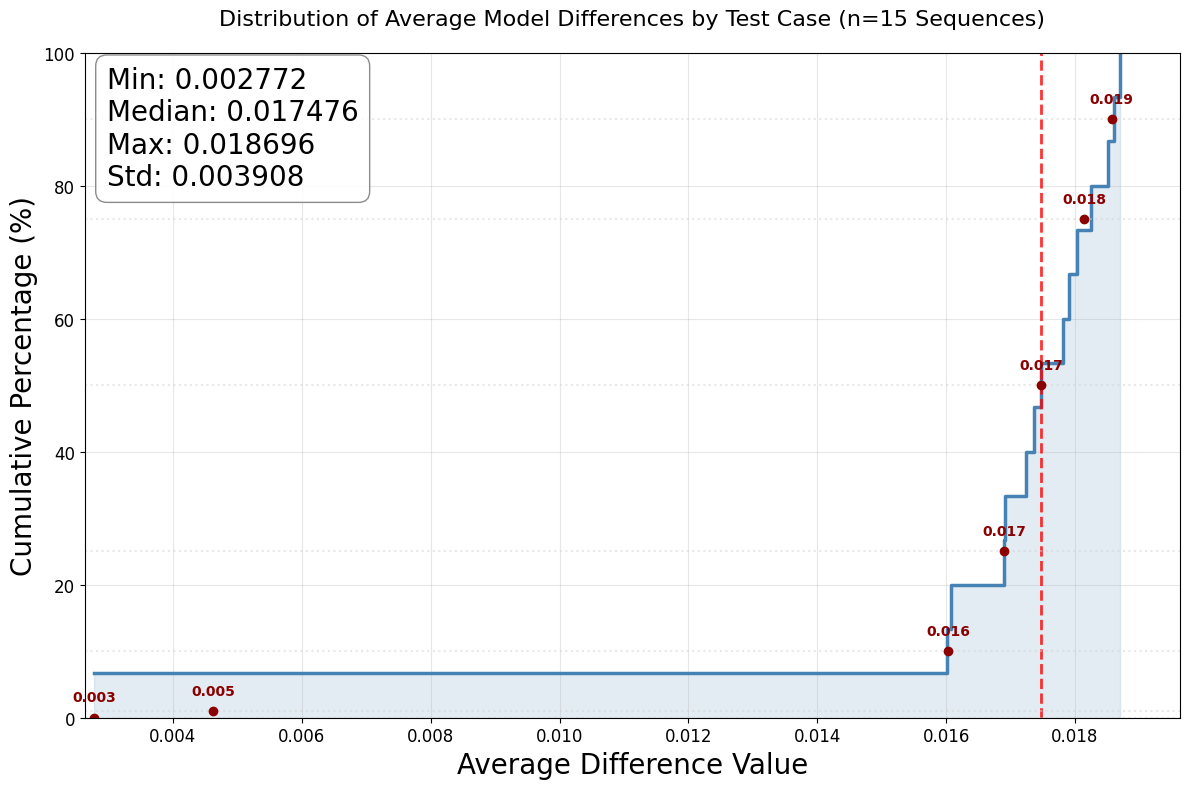

In [3]:
test_case_avg = all_results.groupby('input_text')['abs_calculation_difference'].mean().reset_index()
test_case_avg.columns = ['input_text', 'mean_cross_model_difference']

# Now create the plot
plt.figure(figsize=(12, 8))

sorted_data = test_case_avg['mean_cross_model_difference'].sort_values()
y_values = np.arange(1, len(sorted_data) + 1) / len(sorted_data) * 100

# Main curve - cleaner styling
plt.step(sorted_data, y_values, where='post', color='steelblue', linewidth=2.5)
plt.fill_between(sorted_data, y_values, alpha=0.15, color='steelblue', step='post')

# Median line
median_value = sorted_data.median()
plt.axvline(x=median_value, color='red', linestyle='--', alpha=0.8, linewidth=2)

# Simplified percentiles - only show key ones
key_percentiles = [0, 1, 10, 25, 50, 75, 90]
for pct in key_percentiles:
    percentile_value = sorted_data.quantile(pct/100)
    plt.axhline(y=pct, color='lightgray', linestyle=':', alpha=0.5)
    plt.plot(percentile_value, pct, marker='o', color='darkred', markersize=6)
    # Better text positioning
    plt.text(percentile_value, pct + 2, f"{percentile_value:.3f}", 
            color='darkred', ha='center', va='bottom', fontweight='bold', fontsize=10)

# Clean grid and labels
plt.grid(True, linestyle='-', alpha=0.3)
plt.title(f'Distribution of Average Model Differences by Test Case (n={len(sorted_data)} Sequences)', 
          fontsize=16, pad=20)
plt.xlabel('Average Difference Value', fontsize=20)
plt.ylabel('Cumulative Percentage (%)', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Better axis limits
plt.xlim(sorted_data.min() * 0.95, sorted_data.max() * 1.05)
plt.ylim(0, 100)

# Cleaner ticks
plt.yticks(np.arange(0, 101, 20))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Simplified stats box
stats_text = (f"Min: {sorted_data.min():.6f}\n"
              f"Median: {median_value:.6f}\n" 
              f"Max: {sorted_data.max():.6f}\n"
              f"Std: {sorted_data.std():.6f}")

plt.text(0.02, 0.98, stats_text, transform=plt.gca().transAxes, fontsize=20,
        verticalalignment='top', horizontalalignment='left',
        bbox=dict(boxstyle='round,pad=0.4', facecolor='white', alpha=0.9, edgecolor='gray'))

plt.tight_layout()

# Save plot
save_path = 'Cumulative Distribution of Average Differences by Test Case ForL.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()


In [90]:
import re
import pandas as pd
import numpy as np

def extract_block_number(layer_name):
    patterns = [
        r'model\.layers\.(\d+)',   # Llama-style: model.layers.0.self_attn, model.layers.15.mlp
    ]
    
    for pattern in patterns:
        match = re.search(pattern, layer_name)
        if match:
            return int(match.group(1))
    
    return -1

def extract_component_type(layer_name):
    component_map = {
        'self_attn': 'self_attention',
        'mlp': 'mlp',
        'input_layernorm': 'input_norm',
        'post_attention_layernorm': 'post_attn_norm',
        'embed_tokens': 'embedding',
        'norm': 'norm'
    }
    
    for key, value in component_map.items():
        if key in layer_name:
            return value
    return 'other'

def analyze_llama_models(all_results):
    
    # Add derived columns if they don't exist
    if 'block_number' not in all_results.columns:
        all_results['block_number'] = all_results['layer_name'].apply(extract_block_number)
    if 'component_type' not in all_results.columns:
        all_results['component_type'] = all_results['layer_name'].apply(extract_component_type)
    
    # Use the correct difference columns - let's check what's available
    diff_columns = {
        'calculation_diff': 'abs_calculation_difference',
        'actual_diff': 'abs_actual_difference', 
        'selection_diff': 'selection_difference'
    }
    
    # Calculate test case averages using calculation differences
    block_avg = all_results.groupby(['input_text', 'block_number'])['abs_calculation_difference'].mean().reset_index()
    test_case_avg = block_avg.groupby('input_text')['abs_calculation_difference'].mean().reset_index()
    test_case_avg.columns = ['input_text', 'mean_cross_model_difference']
    
    sorted_data = test_case_avg['mean_cross_model_difference'].sort_values()
    valid_results = all_results[all_results['block_number'] >= 0]
    valid_blocks = valid_results['block_number'].unique() if len(valid_results) > 0 else []
    
    print("=" * 80)
    print("🔍 LLAMA MODEL COMPARISON ANALYSIS")
    print("=" * 80)
    
    # Dataset Overview
    print(f"\n📊 Dataset Overview:")
    print(f"   Test cases analyzed: {len(sorted_data):,}")
    print(f"   Total layer comparisons: {len(all_results):,}")
    print(f"   Transformer layers detected: {len(valid_blocks)}")
    if len(valid_blocks) > 0:
        print(f"   Layer range: {min(valid_blocks)} → {max(valid_blocks)}")
    
    # Show available difference metrics
    print(f"\n📏 Available Difference Metrics:")
    for col in ['abs_calculation_difference', 'abs_actual_difference', 'calculation_difference', 'actual_difference']:
        if col in all_results.columns:
            mean_val = all_results[col].mean()
            print(f"   {col}: mean = {mean_val:.6f}")
    
    # Statistical Summary (using calculation differences)
    print(f"\n📈 Statistical Summary (Calculation Differences):")
    stats = {
        'Minimum': sorted_data.min(),
        'Maximum': sorted_data.max(),
        'Mean': sorted_data.mean(),
        'Median': sorted_data.median(),
        'Std Dev': sorted_data.std(),
        'Range': sorted_data.max() - sorted_data.min()
    }
    
    for name, value in stats.items():
        print(f"   {name:<10}: {value:.6f}")
    
    # Percentile Analysis
    print(f"\n📊 Percentile Distribution:")
    percentiles = [1, 5, 10, 25, 50, 75, 90, 95, 99]
    for pct in percentiles:
        value = sorted_data.quantile(pct/100)
        print(f"   {pct:2d}th percentile: {value:.6f}")
    
    # Threshold Analysis
    print(f"\n🎯 Threshold Analysis:")
    thresholds = [0.001, 0.005, 0.01, 0.02, 0.05, 0.1]
    for threshold in thresholds:
        pct_below = (sorted_data < threshold).sum() / len(sorted_data) * 100
        print(f"   < {threshold:5.3f}: {pct_below:5.1f}% of test cases")
    
    # Extreme Cases
    print(f"\n🔥 Highest Differences (Top 5):")
    top_5 = test_case_avg.nlargest(5, 'mean_cross_model_difference')
    for i, (_, row) in enumerate(top_5.iterrows(), 1):
        text_preview = row['input_text'][:60] + "..." if len(row['input_text']) > 60 else row['input_text']
        print(f"   {i}. {row['mean_cross_model_difference']:.6f} → \"{text_preview}\"")
    
    print(f"\n❄️  Lowest Differences (Top 5):")
    bottom_5 = test_case_avg.nsmallest(5, 'mean_cross_model_difference')
    for i, (_, row) in enumerate(bottom_5.iterrows(), 1):
        text_preview = row['input_text'][:60] + "..." if len(row['input_text']) > 60 else row['input_text']
        print(f"   {i}. {row['mean_cross_model_difference']:.6f} → \"{text_preview}\"")
    
    # Layer-Level Analysis
    if len(valid_results) > 0:
        print(f"\n" + "=" * 60)
        print("🏗️  LAYER-BY-LAYER ANALYSIS")
        print("=" * 60)
        
        layer_stats = valid_results.groupby('block_number')['abs_calculation_difference'].agg([
            'count', 'mean', 'std', 'min', 'max'
        ]).round(6)
        
        print(f"\n📋 Per-Layer Statistics (Calculation Differences):")
        print(f"{'Layer':<6} {'Count':<8} {'Mean':<12} {'Std':<12} {'Min':<12} {'Max':<12}")
        print("-" * 70)
        
        for layer_num in sorted(layer_stats.index):
            stats = layer_stats.loc[layer_num]
            print(f"{layer_num:<6} {stats['count']:<8} {stats['mean']:<12.6f} "
                  f"{stats['std']:<12.6f} {stats['min']:<12.6f} {stats['max']:<12.6f}")
        
        # Component Analysis
        print(f"\n🧩 Component Type Analysis:")
        component_stats = all_results.groupby('component_type')['abs_calculation_difference'].agg([
            'count', 'mean', 'std', 'min', 'max'
        ]).round(6)
        
        print(f"{'Component':<20} {'Count':<8} {'Mean':<12} {'Std':<12}")
        print("-" * 55)
        
        for component in sorted(component_stats.index):
            stats = component_stats.loc[component]
            print(f"{component:<20} {stats['count']:<8} {stats['mean']:<12.6f} {stats['std']:<12.6f}")
        
        # Layer Type Analysis (using the layer_type column)
        if 'layer_type' in all_results.columns:
            print(f"\n🔧 Layer Type Analysis:")
            layer_type_stats = all_results.groupby('layer_type')['abs_calculation_difference'].agg([
                'count', 'mean', 'std'
            ]).round(6)
            
            print(f"{'Layer Type':<20} {'Count':<8} {'Mean':<12} {'Std':<12}")
            print("-" * 55)
            
            for layer_type in sorted(layer_type_stats.index):
                stats = layer_type_stats.loc[layer_type]
                print(f"{layer_type:<20} {stats['count']:<8} {stats['mean']:<12.6f} {stats['std']:<12.6f}")
    
    # Error Analysis
    if 'error' in all_results.columns:
        print(f"\n⚠️  Error Analysis:")
        error_counts = all_results['error'].value_counts()
        total_entries = len(all_results)
        
        for error_type, count in error_counts.items():
            pct = count / total_entries * 100
            print(f"   {error_type}: {count:,} ({pct:.1f}%)")
    
    # Selection Method Analysis
    if 'selection_method' in all_results.columns:
        print(f"\n🎯 Selection Method Analysis:")
        selection_stats = all_results.groupby('selection_method')['abs_calculation_difference'].agg([
            'count', 'mean', 'std'
        ]).round(6)
        
        print(f"{'Method':<15} {'Count':<8} {'Mean':<12} {'Std':<12}")
        print("-" * 50)
        
        for method in sorted(selection_stats.index):
            stats = selection_stats.loc[method]
            print(f"{method:<15} {stats['count']:<8} {stats['mean']:<12.6f} {stats['std']:<12.6f}")
    
    # Unparsed Layers
    unparsed = all_results[all_results['block_number'] == -1]
    if len(unparsed) > 0:
        print(f"\n⚠️  Unparsed Layers:")
        print(f"   Found {len(unparsed):,} entries from {len(unparsed['layer_name'].unique())} unique layer names")
        print(f"   Sample unparsed layers:")
        
        unique_unparsed = unparsed['layer_name'].unique()
        for i, layer in enumerate(unique_unparsed[:8], 1):
            print(f"   {i}. {layer}")
        
        if len(unique_unparsed) > 8:
            print(f"   ... and {len(unique_unparsed) - 8} more")
    
    # Multi-metric comparison
    print(f"\n" + "=" * 60)
    print("📊 MULTI-METRIC COMPARISON")
    print("=" * 60)
    
    metrics = ['abs_calculation_difference', 'abs_actual_difference']
    available_metrics = [m for m in metrics if m in all_results.columns]
    
    if len(available_metrics) > 1:
        print(f"\nCorrelation between difference metrics:")
        for i, metric1 in enumerate(available_metrics):
            for metric2 in available_metrics[i+1:]:
                corr = all_results[metric1].corr(all_results[metric2])
                print(f"   {metric1} ↔ {metric2}: {corr:.4f}")
    
    # Summary Insights
    print(f"\n" + "=" * 60)
    print("💡 KEY INSIGHTS")
    print("=" * 60)
    
    high_diff_pct = (sorted_data > 0.01).sum() / len(sorted_data) * 100
    low_diff_pct = (sorted_data < 0.001).sum() / len(sorted_data) * 100
    
    print(f"   • {high_diff_pct:.1f}% of test cases show substantial differences (>0.01)")
    print(f"   • {low_diff_pct:.1f}% of test cases show minimal differences (<0.001)")
    print(f"   • Average difference across all test cases: {sorted_data.mean():.6f}")
    
    if len(valid_results) > 0:
        layer_means = valid_results.groupby('block_number')['abs_calculation_difference'].mean()
        most_different_layer = layer_means.idxmax()
        least_different_layer = layer_means.idxmin()
        
        print(f"   • Most different layer: {most_different_layer} (avg: {layer_means.max():.6f})")
        print(f"   • Least different layer: {least_different_layer} (avg: {layer_means.min():.6f})")
    
    print(f"\n" + "=" * 80)
    print("✅ ANALYSIS COMPLETE")
    print("=" * 80)
    
    return test_case_avg, layer_stats if len(valid_results) > 0 else None, component_stats if len(valid_results) > 0 else None

# Run the analysis
test_case_results, layer_results, component_results = analyze_llama_models(all_results)


🔍 LLAMA MODEL COMPARISON ANALYSIS

📊 Dataset Overview:
   Test cases analyzed: 15
   Total layer comparisons: 61,686
   Transformer layers detected: 32
   Layer range: 0 → 31

📏 Available Difference Metrics:
   abs_calculation_difference: mean = 0.017500
   abs_actual_difference: mean = 0.000009
   calculation_difference: mean = 0.000180
   actual_difference: mean = 0.000001

📈 Statistical Summary (Calculation Differences):
   Minimum   : 0.003634
   Maximum   : 0.027336
   Mean      : 0.021335
   Median    : 0.022064
   Std Dev   : 0.005440
   Range     : 0.023702

📊 Percentile Distribution:
    1th percentile: 0.005707
    5th percentile: 0.014002
   10th percentile: 0.018862
   25th percentile: 0.020828
   50th percentile: 0.022064
   75th percentile: 0.024057
   90th percentile: 0.025460
   95th percentile: 0.026399
   99th percentile: 0.027148

🎯 Threshold Analysis:
   < 0.001:   0.0% of test cases
   < 0.005:   6.7% of test cases
   < 0.010:   6.7% of test cases
   < 0.020:  20.0

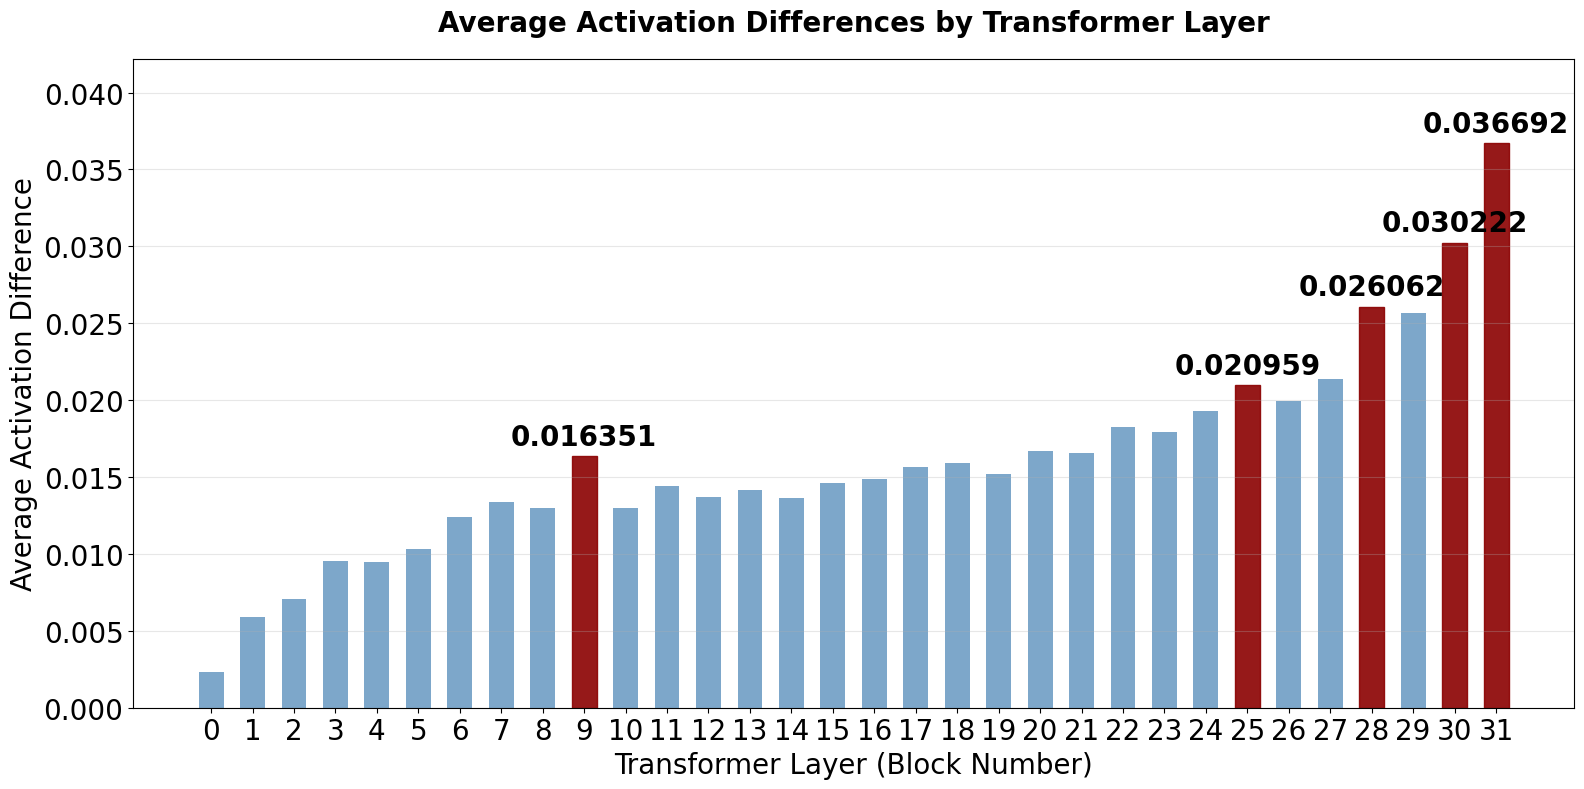

In [97]:
import matplotlib.pyplot as plt
import numpy as np

# Filter valid results and calculate column averages
valid_results = all_results[all_results['block_number'] >= 0].copy()
column_averages = valid_results.groupby('block_number')['abs_calculation_difference'].mean().sort_index()

plt.figure(figsize=(16, 8))

layers = column_averages.index.tolist()
avg_values = column_averages.values

# Create bar plot
bars = plt.bar(layers, avg_values, color='steelblue', alpha=0.7, width=0.6)

# Highlight top 3 layers + blocks 9 and 25
top_3_layers = column_averages.nlargest(3)
red_layers = list(top_3_layers.index) + [9, 25]

# Only add numbers on red bars
for layer_num in red_layers:
    if layer_num in layers:
        idx = layers.index(layer_num)
        bars[idx].set_color('darkred')
        bars[idx].set_alpha(0.9)
        # Add value label only on red bars
        value = avg_values[idx]
        plt.text(layer_num, value + max(avg_values) * 0.01, 
                f'{value:.6f}', 
                ha='center', va='bottom', 
                fontsize=20, fontweight='bold')

plt.title('Average Activation Differences by Transformer Layer', 
          fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Transformer Layer (Block Number)', fontsize=20)
plt.ylabel('Average Activation Difference', fontsize=20)
plt.grid(True, alpha=0.3, axis='y')

# Set y-axis to start from 0 and add some padding at top
plt.ylim(0, max(avg_values) * 1.15)

# Ensure all layer numbers are shown on x-axis
plt.xticks(layers, rotation=0, fontsize=20)
plt.yticks(fontsize=20)

plt.tight_layout()
plt.show()


In [101]:
avg_values[9:25].mean()

0.01564023463895913

<Figure size 1400x800 with 0 Axes>

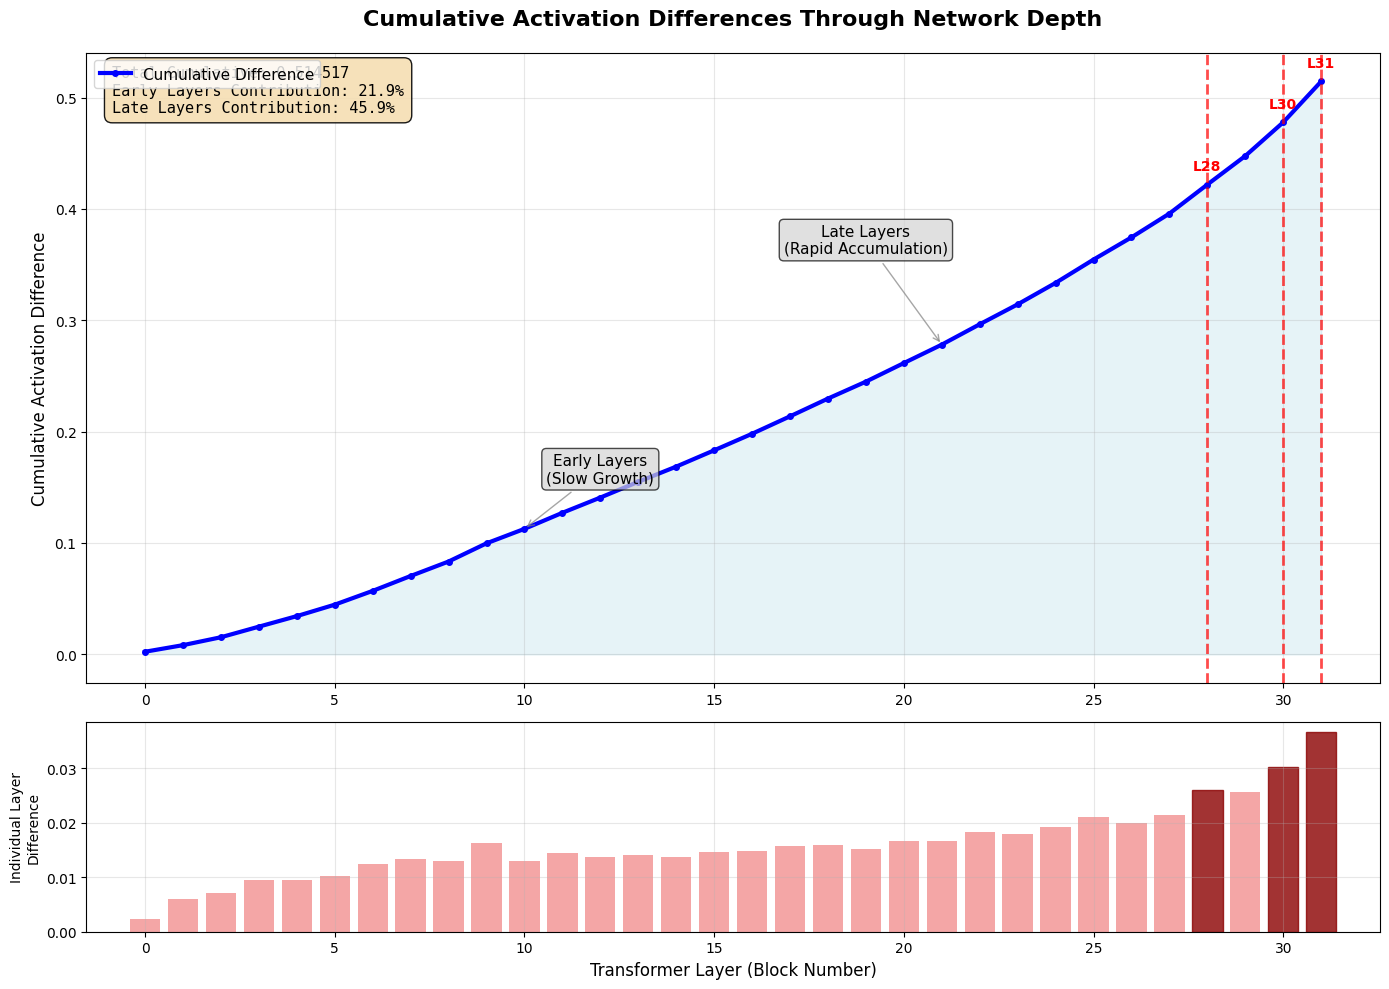


📊 Cumulative Difference Analysis:
   Total cumulative difference: 0.514517
   Average per-layer contribution: 0.016079
   Highest contributing layers:
      1. Layer 31: 0.036692 (7.1% of total)
      2. Layer 30: 0.030222 (5.9% of total)
      3. Layer 28: 0.026062 (5.1% of total)
   Early layers (0-10) contribute: 21.9%
   Late layers (21-31) contribute: 45.9%


In [92]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def create_cumulative_difference_plot(all_results):
    # Filter valid results and calculate layer-wise means
    valid_results = all_results[all_results['block_number'] >= 0].copy()
    
    # Calculate mean difference per layer
    layer_means = valid_results.groupby('block_number')['abs_calculation_difference'].mean().sort_index()
    
    # Calculate cumulative differences
    cumulative_diff = layer_means.cumsum()
    layers = layer_means.index.tolist()
    layer_values = layer_means.values
    
    plt.figure(figsize=(14, 8))
    
    # Create subplot with two y-axes
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), height_ratios=[3, 1])
    
    # Main plot: Cumulative differences
    ax1.plot(layers, cumulative_diff.values, 'b-', linewidth=3, 
             label='Cumulative Difference', marker='o', markersize=4)
    ax1.fill_between(layers, cumulative_diff.values, alpha=0.3, color='lightblue')
    
    # Highlight critical layers (top 3 highest individual differences)
    top_layers = layer_means.nlargest(3)
    for layer_num in top_layers.index:
        ax1.axvline(x=layer_num, color='red', linestyle='--', alpha=0.7, linewidth=2)
        ax1.text(layer_num, cumulative_diff[layer_num] + cumulative_diff.max() * 0.02, 
                f'L{layer_num}', ha='center', va='bottom', color='red', 
                fontweight='bold', fontsize=10)
    
    # Add annotations for phases
    early_phase_end = len(layers) // 3
    late_phase_start = 2 * len(layers) // 3
    
    if len(layers) > 6:
        ax1.annotate('Early Layers\n(Slow Growth)', 
                    xy=(early_phase_end, cumulative_diff.iloc[early_phase_end]), 
                    xytext=(early_phase_end + 2, cumulative_diff.max() * 0.3),
                    fontsize=11, ha='center',
                    arrowprops=dict(arrowstyle='->', color='gray', alpha=0.7),
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgray', alpha=0.7))
        
        ax1.annotate('Late Layers\n(Rapid Accumulation)', 
                    xy=(late_phase_start, cumulative_diff.iloc[late_phase_start]), 
                    xytext=(late_phase_start - 2, cumulative_diff.max() * 0.7),
                    fontsize=11, ha='center',
                    arrowprops=dict(arrowstyle='->', color='gray', alpha=0.7),
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgray', alpha=0.7))
    
    ax1.set_title('Cumulative Activation Differences Through Network Depth', 
                  fontsize=16, fontweight='bold', pad=20)
    ax1.set_ylabel('Cumulative Activation Difference', fontsize=12)
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc='upper left', fontsize=11)
    
    # Secondary plot: Individual layer contributions
    colors = ['orange' if layer_num in top_layers.index else 'lightcoral' 
              for layer_num in layers]
    bars = ax2.bar(layers, layer_values, alpha=0.7, color=colors, width=0.8)
    
    # Highlight top contributing layers
    for i, (layer_num, bar) in enumerate(zip(layers, bars)):
        if layer_num in top_layers.index:
            bar.set_color('darkred')
            bar.set_alpha(0.8)
    
    ax2.set_xlabel('Transformer Layer (Block Number)', fontsize=12)
    ax2.set_ylabel('Individual Layer\nDifference', fontsize=10)
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim(ax1.get_xlim())
    
    # Add summary statistics box
    total_cumulative = cumulative_diff.iloc[-1]
    early_contrib = cumulative_diff.iloc[early_phase_end] if len(layers) > 6 else 0
    late_contrib = cumulative_diff.iloc[-1] - cumulative_diff.iloc[late_phase_start] if len(layers) > 6 else 0
    
    stats_text = f'Total Cumulative: {total_cumulative:.6f}\n'
    if len(layers) > 6:
        stats_text += f'Early Layers Contribution: {early_contrib/total_cumulative*100:.1f}%\n'
        stats_text += f'Late Layers Contribution: {late_contrib/total_cumulative*100:.1f}%'
    
    ax1.text(0.02, 0.98, stats_text, transform=ax1.transAxes, fontsize=11,
             bbox=dict(boxstyle='round,pad=0.5', facecolor='wheat', alpha=0.9),
             verticalalignment='top', fontfamily='monospace')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed insights
    print(f"\n📊 Cumulative Difference Analysis:")
    print(f"   Total cumulative difference: {total_cumulative:.6f}")
    print(f"   Average per-layer contribution: {total_cumulative/len(layers):.6f}")
    print(f"   Highest contributing layers:")
    for i, (layer_num, diff) in enumerate(top_layers.items(), 1):
        contribution_pct = diff / total_cumulative * 100
        print(f"      {i}. Layer {layer_num}: {diff:.6f} ({contribution_pct:.1f}% of total)")
    
    if len(layers) > 6:
        print(f"   Early layers ({layers[0]}-{layers[early_phase_end]}) contribute: {early_contrib/total_cumulative*100:.1f}%")
        print(f"   Late layers ({layers[late_phase_start]}-{layers[-1]}) contribute: {late_contrib/total_cumulative*100:.1f}%")
    
    return cumulative_diff, layer_means

# Generate Plot 5
cumulative_diff, layer_means = create_cumulative_difference_plot(all_results)
